<h2> Importing libraries </h2>

In [1]:
import numpy as np
import cv2, pywt
import os, shutil
import matplotlib
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd

%matplotlib inline

<h2> Setting up the directory locations </h2>

In [2]:
path_of_unprocessed_data = "./images/"
path_of_processed_data = "./processed_images/"
img_dirs = []

def load_data():
    #for unprocessed dataset
    
    for entry in os.scandir(path_of_unprocessed_data):
        if entry.is_dir():
            img_dirs.append(entry.path)

    #intializing directory for processed images
    if os.path.exists(path_of_processed_data):
         shutil.rmtree(path_of_processed_data)
    os.mkdir(path_of_processed_data)

load_data()
img_dirs

['./images/pull_up', './images/running']

<h2>Image augmentation</h2>

In [6]:
def augment_the_image(image, save_path, save_prefix):
    
    datagen = ImageDataGenerator(
                    rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
                    )

    image_array = img_to_array(image)  # this is a Numpy array with shape (3, 150, 150)
    image_array = image_array.reshape((1,) + image_array.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    i = 0
    for batch in datagen.flow(image_array, batch_size=1,
                              save_to_dir=save_path, save_prefix=save_prefix, save_format='jpeg'):
        i += 1
        if i > 20:
            break 

<h2>Performing image augmentation</h2>

In [7]:
images = []
images_paths = []
action_names = []
#getting info of images of everyclass
for img_dir in img_dirs:
    action_name = img_dir.split('/')[-1]
    for entry in os.scandir(img_dir):
        image = cv2.imread(entry.path)
        images.append(image)
        images_paths.append(img_dir)
        action_names.append(action_name)

#augmenting every image found
for i in range(0, len(images)):
    augment_the_image(images[i], images_paths[i], action_names[i]) 

<h2>Getting the area of interest </h2>

In [4]:
def get_roi(image_path):
    pedestrian_cascade = cv2.CascadeClassifier('./haarcascade_fullbody.xml')
    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pedestrians = pedestrian_cascade.detectMultiScale(img, 1.1, 1)
    
    for (x,y,w,h) in pedestrians:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        return roi_color

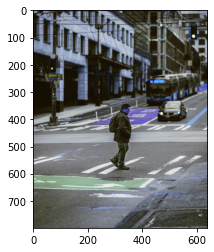

In [5]:
#Example
the_image_path = "./image.JPG"
the_image = cv2.imread(the_image_path)
plt.imshow(the_image)

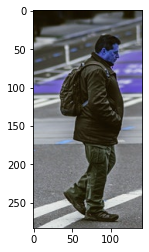

In [6]:
the_image = get_roi(the_image_path)
plt.imshow(the_image)

<h2>Image sharpenning</h2>

In [8]:
def sharpen(image):
    kernel = np.array( [ [0, -1, 0], [-1, 5,-1], [0, -1, 0] ] )
    sharp_image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return sharp_image

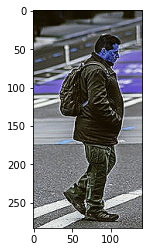

In [9]:
the_image = sharpen(the_image)
plt.imshow(the_image)

<h2>Wavelet Transformation</h2>

In [10]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions (convert to grayscale)
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

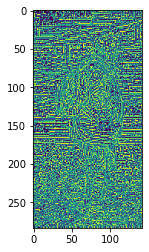

In [11]:
the_image = w2d(the_image)
plt.imshow(the_image)

<h2>Pre-processing the images</h2>

In [ ]:
processed_image_dirs = []
action_file_names_dict = {}
load_data()

for img_dir in img_dirs:
    count = 1
    action_name = img_dir.split('/')[-1]
    action_file_names_dict[action_name] = []
    
    for entry in os.scandir(img_dir):
        
        #creating processed folders for each class
        processed_folder = path_of_processed_data + action_name
        
        if not os.path.exists(processed_folder):
            os.makedirs(processed_folder)
            processed_image_dirs.append(processed_folder)
            print("Generating processed images in folder: ",processed_folder)
            
        #getting region of interest from image
        roi_image = get_roi(entry.path)
        #sharpenning the image
        sharp_image = sharpen(roi_image)
            
        #saving the preprocessed images
        processed_file_name = action_name + str(count) + ".jpg"
        processed_file_path = processed_folder + "/" + processed_file_name
        cv2.imwrite(processed_file_path, sharp_image)
        action_file_names_dict[action_name].append(processed_file_path)
        count += 1
    print("in progress..")

print("Preprocessing done...")

<h2>Labeling the images</h2>

In [9]:
#labeling the classes
class_dict = {}
count = 0
for action_name in action_file_names_dict.keys():
    class_dict[action_name] = count
    count = count + 1
class_dict

{'pull_up': 0, 'running': 1}

<h2>Loading processed images</h2>

In [10]:
#loading the processed images for training and testing
X, y = [], []

for action_name, training_files in action_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        #resizing the image
        scalled_raw_img = cv2.resize(img, (32, 32))
        #applying wavelate transformation
        img_har = w2d(img,'db1',5)
        #resizing the wavelate transformed image
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
            
        X.append(combined_img)
        y.append(class_dict[action_name]) 
        
X = np.array(X).reshape(len(X),4096).astype(float)

<h2>Train-test splitting</h2>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

<h2>Model evaluation</h2>

In [11]:
#Evaluating SVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       610
           1       0.85      0.89      0.87       890

    accuracy                           0.85      1500
   macro avg       0.84      0.83      0.84      1500
weighted avg       0.85      0.85      0.85      1500



In [15]:
#Evaluating the RamdomForestClassifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=50, random_state=5)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       610
           1       0.82      0.89      0.85       890

    accuracy                           0.82      1500
   macro avg       0.82      0.80      0.80      1500
weighted avg       0.82      0.82      0.81      1500



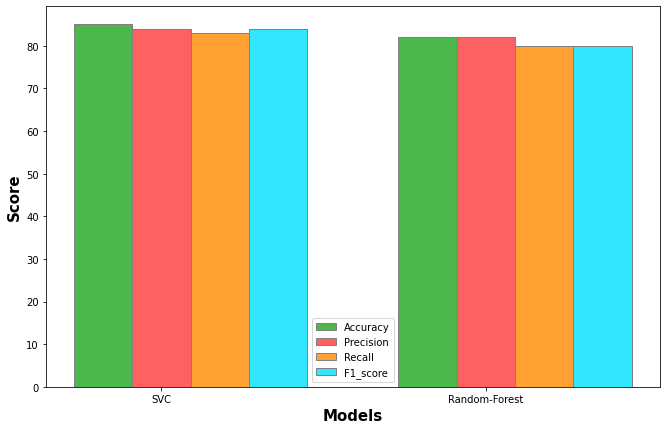

In [37]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.18
fig = plt.subplots(figsize =(11, 7))
 
# set height of bar
'''IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
CSE = [29, 3, 24, 25, 17]'''
Accuracy = [85, 82]
Precision = [84,82]
Recall = [83,80]
F1_score = [84,80]

# Set position of bar on X axis
br1 = np.arange(len(Accuracy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, Accuracy, color ='#4cb84c', width = barWidth,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, Precision, color ='#FE6161', width = barWidth,
        edgecolor ='grey', label ='Precision')
plt.bar(br3, Recall, color ='#FFA233', width = barWidth,
        edgecolor ='grey', label ='Recall')
plt.bar(br4, F1_score, color ='#33E6FF', width = barWidth,
        edgecolor ='grey', label ='F1_score')

# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Accuracy))],
        ['SVC', 'Random-Forest'])
 
plt.legend()
plt.show()